# Lecture 12 - Sampling Models

In [14]:
using DifferentialEquations, ParameterizedFunctions, Distributions, Random, Plots; gr();

## Mass-Spring Model

In [15]:
MS_rhs = @ode_def begin
    dx = y
    dy = -(k/m)*x - (g/m)*y
end m k g;

In [16]:
function solve_MS(m,k,g,u0,u1)
    u0 = [u0, u1]
    tspan = (0.0, 50000.0)
    p = [m, k, g]
    prob = ODEProblem(MS_rhs, u0, tspan, p)
    sol = solve(prob)
    return sol
end;

In [17]:
solve_MS(10,0.5,0.1,4.0,0.0)
@time sol = solve_MS(10,0.5,0.1,4.0,0.0); ##calculate runtime

  0.005204 seconds (54.92 k allocations: 5.273 MiB)


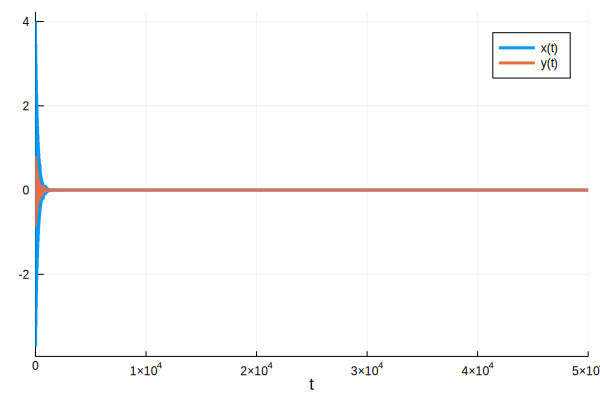

In [5]:
plot(sol)

In [18]:
function eqtime_MS(m,k,g,u0,u1)
    sol = solve_MS(m,k,g,u0,u1)
    threshold = 0.00001
    eqtime = findfirst([sum(y) for y in [abs.(x) for x in sol.u]] .< threshold)
    return sol.t[eqtime]
    end; ##finding equilibrium time

In [19]:
eqtime_MS(10,0.1,0.1,4.0,0.0)
@time eqtime_MS(10,0.1,0.1,4.0,0.0);

  0.002227 seconds (24.32 k allocations: 2.400 MiB)


## Sample the MS system and plot results 

In [20]:
mdist = Normal(10,2) ##between 6 and 14 95% of time 
kdist = Normal(0.1, 0.01) ## between 0.08 and 0.12 95% of time 



Normal{Float64}(μ=0.1, σ=0.01)

In [21]:
N = 100
soul_samples = zeros(N,101)
for i in 1:N
    sol = solve_MS(rand(mdist), rand(kdist), 0.1, 4.0, 0.0)
    soul_samples[i,:] = sol.(0:5:500, idxs=1)
end
    

In [22]:
m_soul = mean(soul_samples,dims=1)
m_input_soul = solve_MS(mean(mdist),mean(kdist), 0.1,4.0,0.0).(0:5:500, idxs=1);

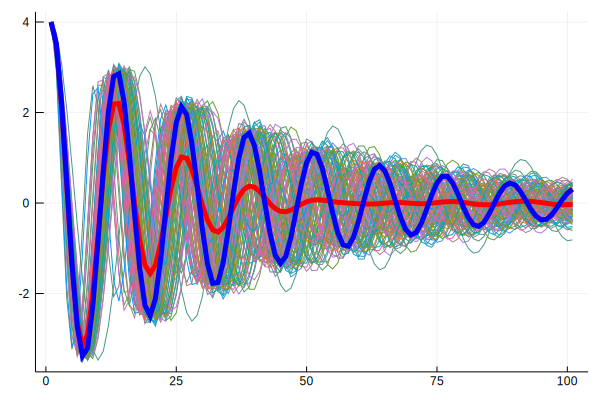

In [12]:
plot(soul_samples', legend=false)
plot!(m_soul', color =:red, linewidth=5) ##average of output
plot!(m_input_soul, color=:blue, linewidth=5) ##output by average input
##They are different b/c the model is not linear

### Sampling the QoI - EqTime

In [23]:
N = 10000
soul_samples = zeros(N)
for i in 1:N
    soul_samples[i] = eqtime_MS(rand(mdist), rand(kdist), 0.1, 4.0, 0.0)
end
    

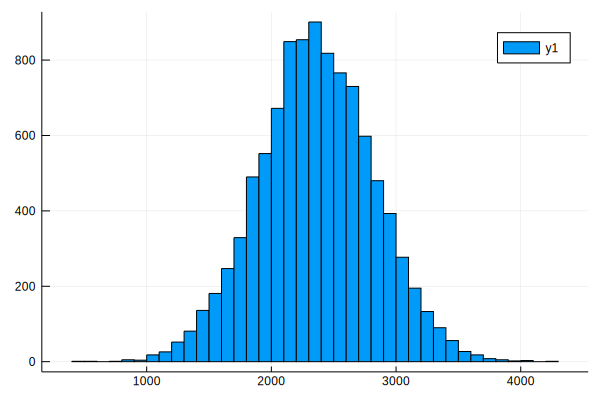

In [24]:
histogram(soul_samples, bins=50)
##distribution of acutal eq time

In [25]:
mean(soul_samples)

2360.23853023267

### Bootstrap for the Mean

In [26]:
rand([1,2,3,4,5],5)
##5 random samples from the vector with replacement

5-element Array{Int64,1}:
 5
 5
 4
 1
 3

In [27]:
M=10000
bs_means = zeros(M)
for i = 1:M
    bootstrap_sample = rand(soul_samples, length(soul_samples))
#     bs_means[i] = mean(bootstrap_sample)
    bs_means[i] = var(bootstrap_sample)
    
end


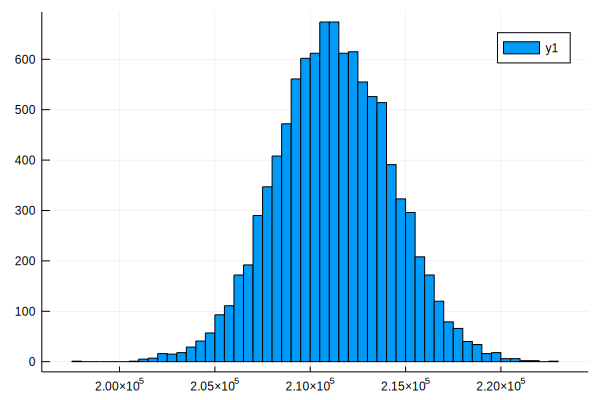

In [28]:
histogram(bs_means, bins=50)
#distribution of mean of eq time

In [29]:
sorted_bs_means = sort(bs_means);

In [30]:
sorted_bs_means[500]
sorted_bs_means[9500]

216166.38873774835

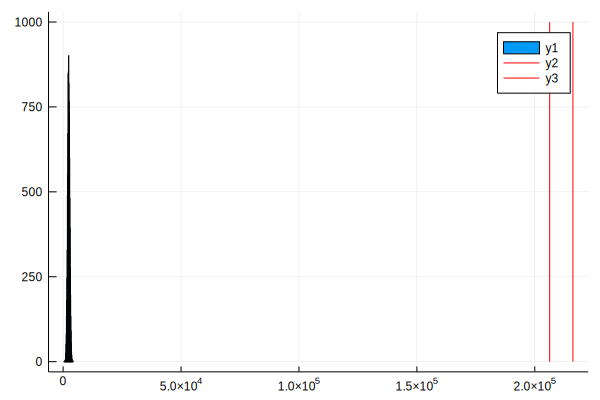

In [31]:
histogram(soul_samples, bins=50)
plot!([sorted_bs_means[500], sorted_bs_means[500]], [0,1000], color=:red, linewidth=1)
plot!([sorted_bs_means[9500], sorted_bs_means[9500]], [0,1000], color=:red, linewidth=1)#, xlimits=(2250,2500))
## it is difficult to find CI of a sample statistic(mean) eq time analytically(math), but computationally(by taking samples) you can easily estimate it. 

## SIR Model

In [32]:
SIR_rhs = @ode_def begin
    ds = - c * s * i
    di = c * s * i - h * i
    dr = h * i
end c h;

In [33]:
function solve_SIR(c,h)
    u0 = [0.99999 0.000001 0.0]
    tspan = (0, 5000.0)
    p = [c , h]
    prob = ODEProblem(SIR_rhs, u0, tspan, p)
    sol = solve(prob)
    return sol
end;

In [34]:
solve_SIR(0.5,0.2)
@time sol = solve_SIR(0.5,0.1);

  0.000188 seconds (843 allocations: 73.781 KiB)


In [35]:
function eqpts_SIR(c,h)
    sol = solve_SIR(c,h) 
    return sol.u[end]
end;

In [36]:
eqpts_SIR(0.5,0.1)
@time eqpts_SIR(0.5,0.2);

  0.000227 seconds (829 allocations: 68.797 KiB)


## Sobol G Function

Defined as

$$ f(\vec{x}) = \prod_{i=1}^N \frac{|4x_i - 2| + a_i}{1-a_i} $$

where

$$ \vec{x} = [x_1, x_2, \cdots, x_N] , \quad x_i \sim \mathbf{U}(0,1)$$

and

$$ a_i = \frac{i - 2}{2} \text{ for all } i = 1, \cdots, N .$$

In [37]:
function solve_SB(x; a=[0, 0.25, 99.0]) ## a is bigger -> less impact on xi???
    if length(x) != length(a)
        error("Vectors must be the same dimension")
    else
        y = prod([(abs(4*x[i] - 2) + a[i])./(1+a[i]) for i = 1:length(x)]) #take product of all of the things 
    end
    return y
end;

In [38]:
solve_SB([0.1 0.2 0.3])
@time sol = solve_SB([0.1 0.2 0.4]);

  0.000046 seconds (15 allocations: 704 bytes)


In [39]:
solve_SB([0.7,0.2,0.9]) ##output is sensitive to change of the first input but not to change of the third input
solve_SB([0.7,0.2,0.3])
solve_SB([0.1,0.2,0.3])

1.852288

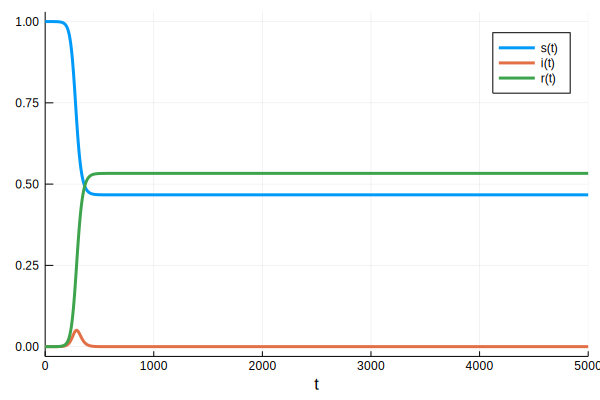

In [40]:
plot(solve_SIR(1/7,1/10))

In [28]:
eqpts_SIR(1/7,1/10) #each state of eq time

1×3 Array{Float64,2}:
 0.466984  -2.06786e-12  0.533007

In [41]:
cdist = Uniform(1/5,1/4)
hdist = Uniform(1/10,1/7)

Uniform{Float64}(a=0.1, b=0.14285714285714285)

In [42]:
mean_sol = solve_SIR(mean(cdist), mean(hdist)) ##gives t(1st element) and u(2nd element) 
#mean_sol.u

retcode: Success
Interpolation: Automatic order switching interpolation
t: 46-element Array{Float64,1}:
    0.0               
    0.6414209967905576
    6.2153084574715995
   17.067633126316547 
   29.664541469300453 
   43.17367755436828  
   56.62569867363361  
   69.55121175087618  
   82.02725223951491  
   94.37224144344655  
  106.9550288820716   
  120.00195402091525  
  133.76614445293453  
    ⋮                 
  851.9873189557927   
  903.3770018794343   
  956.0613353703491   
 1009.76468324859     
 1118.0849598934192   
 1231.8598122856454   
 1376.798235679761    
 1574.5608237388753   
 1867.2870471528527   
 2343.2902101671575   
 3213.0312227760296   
 5000.0               
u: 46-element Array{Array{Float64,2},1}:
 [0.99999 1.0e-6 0.0]                                            
 [0.9999898507801586 1.0686876871093847e-6 8.053215432798868e-8] 
 [0.9999880371277183 1.9035327506998934e-6 1.0593395309492349e-6]
 [0.9999794498498233 5.856331398509467e-6 5.693818778129153

In [43]:
N = 100
tvec = 0:5:500
outputs = zeros(N, length(tvec))
for i=1:N
    sol = solve_SIR(rand(cdist),rand(hdist))
    outputs[i,:] = sol(tvec, idxs=2)
end

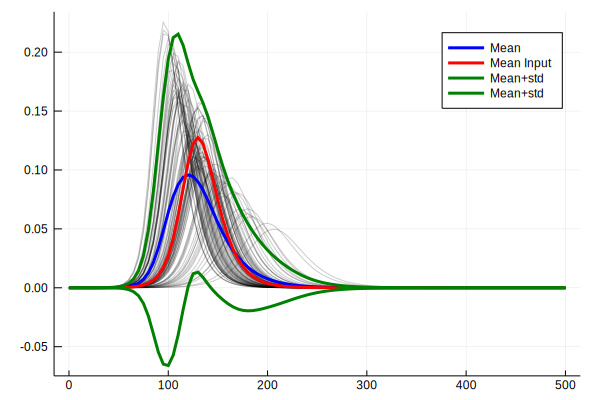

In [48]:
plot(tvec, outputs', label="", color=:black, alpha=0.2) #each curve is a solution so we have whole collection of solutions
plot!(tvec, mean(outputs', dims=2), color=:blue, linewidth=3, label = "Mean")
plot!(tvec, mean_sol(tvec,idxs=2).u,color=:red,linewidth=3, label="Mean Input")
plot!(tvec, mean(outputs', dims=2) + 2*std(outputs',dims=2), color=:green, linewidth=3, label = "Mean+std") ##something above mean
plot!(tvec, mean(outputs', dims=2) - 2*std(outputs',dims=2), color=:green, linewidth=3, label = "Mean+std") ##something below mean, and gets negative

In [49]:
findfirst(tvec.>100)

22

In [50]:
tvec[21]

100

In [52]:
subsample = outputs[:, 21];

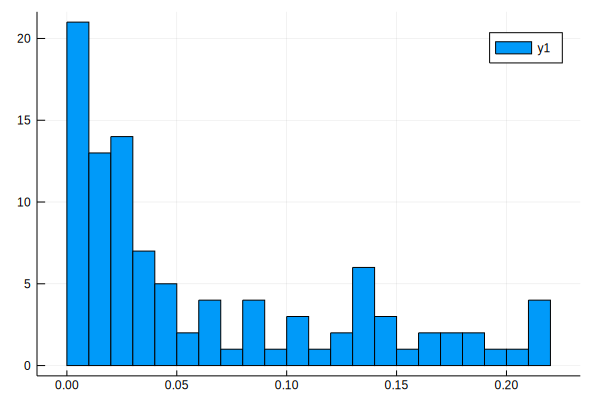

In [54]:
histogram(subsample, bins=20) ##solution of each individual at 100 day # non-negative b/c percentage of population infected after 100 days
#making assumption that dist is symmetricm although it is not actually symmetric, leading to get negative value when plotting mean-2*std

In [44]:
sort(subsample)[5]

UndefVarError: UndefVarError: subsample not defined

In [56]:
sort(subsample)[95]

0.19922170694257058

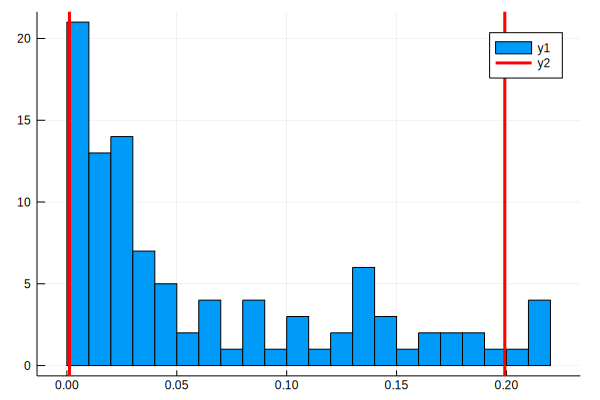

In [57]:
histogram(subsample, bins=20)
vline!([sort(subsample)[5],sort(subsample)[95]], color=:red, linewidth=3) ##95% confidence interval (better representation than mean+/- std)

In [62]:
a = 0:5:500

0:5:500

ErrorException: type Float64 has no field u